In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
#using ForwardDiff
#using ProgressMeter
#using BenchmarkTools;

In [4]:
#Hyperparameters
n = 10
N = 40
σₐ = 0.001
k_range = 6
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
k_list_lite = [i for i in 1:k_range];

In [5]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

mₖ(k) = k*4 + 1;

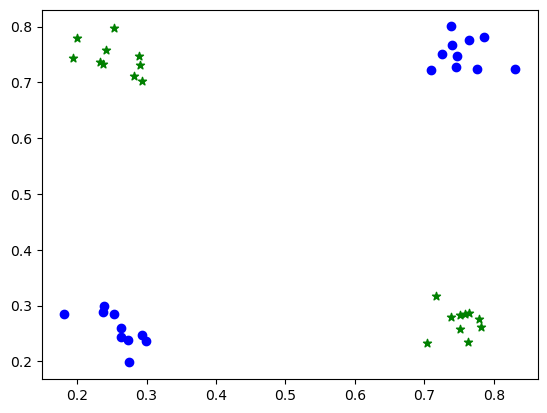

In [6]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.25, 0.75]
    μ₃ = [0.75, 0.75]
    μ₄ = [0.75, 0.25]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

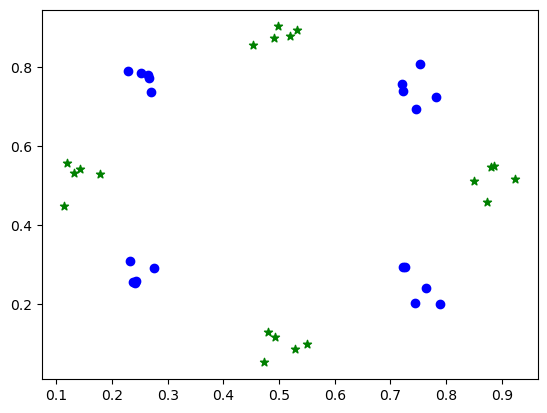

In [27]:
#Scale up - Fixed Separable Data - Multi-XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.5, 0.125]
    μ₃ = [0.25, 0.75]
    μ₄ = [0.125, 0.50]
    μ₅ = [0.75, 0.75]
    μ₆ = [0.50, 0.875]
    μ₇ = [0.75, 0.25]
    μ₈ = [0.875, 0.50]
    μ = [μ₁, μ₂, μ₃, μ₄, μ₅, μ₆, μ₇, μ₈]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/8), 8, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

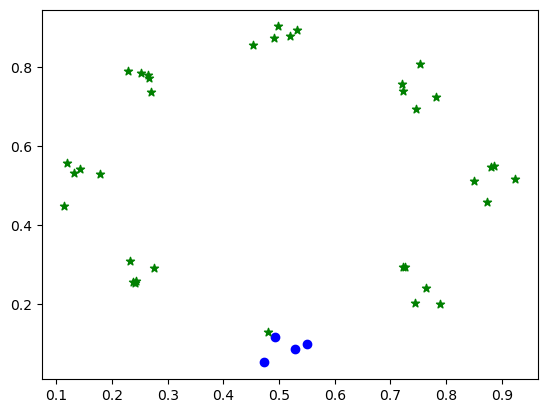

In [33]:
#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, relu),
               Dense(W₂, b₂))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 100.0::Float64
    
    k ~ uniform_discrete(1,k_range) #Number of hidden nodes
    #k ~ k_count(1,0.5,1) #Shifted Negative Binomial
    #println(k)
    
    #Create individual weight and bias vectors
    m = mₖ(k)
    h = 2*k
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)

    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))
    
    #Logistic Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

predictions = classifier(data)
preds = data_labeller(predictions)
plot_data(data_raw,preds)

In [34]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = classes .- 1
obs = obs_master;

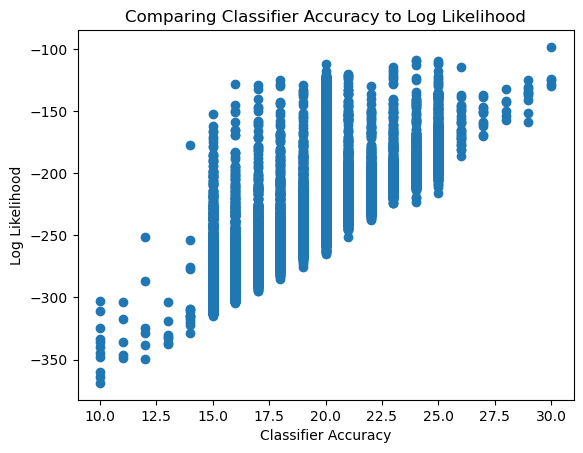

4

In [35]:
#Plot of Log Likelihood Scores
scores = []
accs = []
ks = []
(best_trace,) = generate(classifier, (data,), obs)
best_score = get_score(best_trace)/length(classes)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k)
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([best_trace[:y][i] == best_pred_labels[i] for i=1:length(classes)])/length(classes)

function likelihood(best_acc)
    (trace,) = generate(classifier, (data,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)

    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)/length(classes)
    if acc > best_acc
        best_score = score
        best_trace = trace
        best_acc = acc
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
    push!(ks, k)
end

for i=1:100000
    likelihood(best_acc)
end

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");
print(best_k)

In [36]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    #new_k = previous_k + 1
    difference = abs(new_k - previous_k)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = classes .- 1
    obs_new[:Wₕ] = vcat(Wₕ,[rand(1)[1] for i=1:(2*difference)])
    obs_new[:Wₒ] = vcat(Wₒ,[rand(1)[1] for i=1:difference])
    obs_new[:bₕ] = vcat(bₕ,[rand(1)[1] for i=1:difference])
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (data,), obs_new)
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = classes .- 1
    obs_new[:Wₕ] = Wₕ[1:new_k*2]
    obs_new[:Wₒ] = Wₒ[1:new_k]
    obs_new[:bₕ] = bₕ[1:new_k]
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (data,), obs_new)
    return new_trace
end;

In [41]:
traces = []
acc = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=8, eps=0.01, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
    end
    return trace
end

function across_dimension(trace, iters, obs)
    selection = select(:Wₕ,:bₕ,:Wₒ,:bₒ,:k)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    
    new_trace = birth_or_death(trace)
    
    #test = true
    for i=1:3
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=8, eps=0.01, check=false, observations=obs)
        #accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    score1 = exp(get_score(trace)/length(data))
    score2 = exp(get_score(new_trace)/length(data))
    score = score2/score1
    #println(score)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
        push!(acc,true)
    else
        #println("Sticking with the old k!")
        accepted = false
        push!(acc,false)
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        if i%5000 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
        
        if rand(Uniform(0,1)) > 0.5
            (trace, k) = across_dimension(trace, 1, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
starting_trace = best_trace
#(starting_trace,) = generate(classifier, (data,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,120000);

Beginning RJMCMC. Starting k: 4
Epoch 5000 Acceptance Prob: 0.790735254511177
Epoch 10000 Acceptance Prob: 0.6310217755443887
Epoch 15000 Acceptance Prob: 0.5315623472968771
Epoch 20000 Acceptance Prob: 0.48414975974372665
Epoch 25000 Acceptance Prob: 0.45384430626351047
Epoch 30000 Acceptance Prob: 0.4346016911437472
Epoch 35000 Acceptance Prob: 0.42136481537992065
Epoch 40000 Acceptance Prob: 0.4101866835721793
Epoch 45000 Acceptance Prob: 0.4019065692132066
Epoch 50000 Acceptance Prob: 0.3996076913838887
Epoch 55000 Acceptance Prob: 0.42076018780254043
Epoch 60000 Acceptance Prob: 0.44788422176737563
Epoch 65000 Acceptance Prob: 0.4714347343769259
Epoch 70000 Acceptance Prob: 0.492999389592553
Epoch 75000 Acceptance Prob: 0.5113071028719418
Epoch 80000 Acceptance Prob: 0.5274821511977047
Epoch 85000 Acceptance Prob: 0.5415887923858586
Epoch 90000 Acceptance Prob: 0.5532751610126733
Epoch 95000 Acceptance Prob: 0.5638428008998875
Epoch 100000 Acceptance Prob: 0.5738080449867431
Epoch

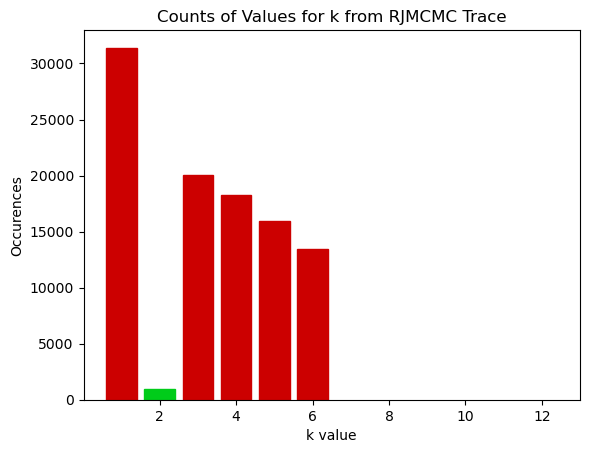

In [42]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 20000:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

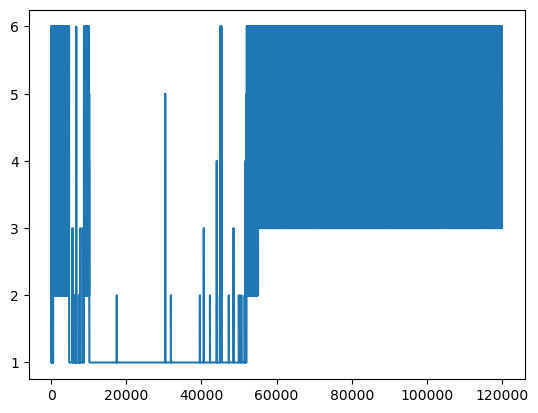

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff3118672d0>

In [43]:
plot(ks)

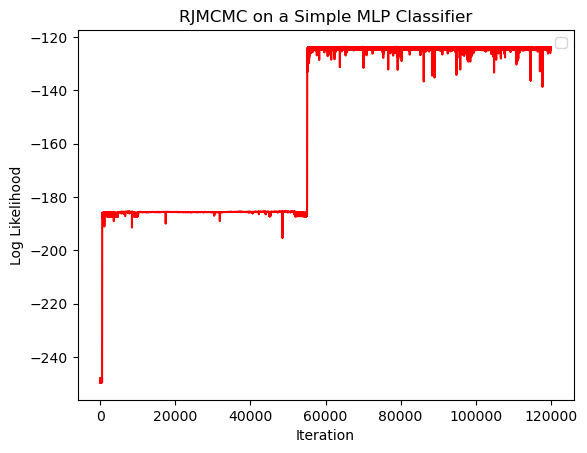

No handles with labels found to put in legend.


In [44]:
#hmc_traces_master = vcat(hmc_traces, hmc_traces2, hmc_traces3, hmc_traces4);
scores2 = zeros(length(traces))
for i=1:length(traces)
    trace = traces[i]
    obs = obs_master
    scores2[i] = get_score(trace)/length(classes)
end
plot(scores2, color="red")
#plot(scores2, color="green")
plt.title("RJMCMC on a Simple MLP Classifier")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
#plt.axvline(100,label="Burn-In: ~1000",color="red")
plt.legend();

In [55]:
index = 1

1

In [40]:
#Uncertainty Plotting
x_grid = zeros((20000,2));
for i=1:20000
    x_grid[i,:] = rand(1,2)
end
x_grid2 = transpose(x_grid);
print(size(x_grid2))
print(size(data))

function plot_many(index)
    obs_sample = choicemap()::ChoiceMap
    obs_sample[:k] = traces[index][:k]
    obs_sample[:Θ] = traces[index][:Θ]
    (trace_pred, _) = generate(classifier, (x_grid2,), obs_sample)
    #predict_scores = [trace_pred[(:y,i)] for i=1:length(x_grid[:,1])]
    predict_scores = trace_pred[:y]
    predict_labels = data_labeller(predict_scores)
    plot_data(x_grid, predict_labels, 0.002)
end


for i=1:300
    index = rand((1000,30000))
    plot_many(index)
end

#index += 10
#print(index)

#plt.title("Basic Uncertainty Visualization: RJMCMC-HMC");

(2, 20000)(2, 200)

ErrorException: No random choice or generative function call at address Θ